In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_sentenceattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","entity_map_ev","entity_ev","synonym","voice","split"],skiprows=1)

Using custom data configuration default-cfbf7584a6bb7c13
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 183.54it/s]


In [3]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gem_exp', 'gem_label', 'gpt_label', 'gpt_exp', 'gold_exp', 'entity_map_ev', 'entity_ev', 'synonym', 'voice', 'split'],
    num_rows: 2322
})

In [4]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-aa1fd4d2889f655e.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9cd628f4430f2ace.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-df968f39da4ad12a.arrow


In [5]:
columns_to_keep = ["claim", "premise", "label","category"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category'],
        num_rows: 234
    })
})

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e8dc3bd2c646ced3.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-7bec47e524518b7d.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e2623f6a029e90cb.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [8]:
print(type(dataset["train"]["claim"]))

<class 'list'>


In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='pritamdeka/PubMedBERT-MNLI-MedNLI'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences,claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        if 'label' in item:
            item['labels'] = torch.tensor(item['label'], dtype=torch.long)
        
        return item



In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [14]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category'],
    num_rows: 1623
})

In [15]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [16]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [17]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [18]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [19]:
tdata.__getitem__(18)

{'claim': 'Triglycerides are stored in your fat cells.',
 'premise': 'The hydrolysis of the triglycerides stored in the fat cell is a complex phenomenon involving lipases, plasma membrane transporters, fatty acid binding proteins and proteins associated with the lipid droplet.',
 'label': 1,
 'category': 'General Health',
 'input_ids': tensor([    2,  1920,  9128,  1927,  1920, 13631,  6574,  1922,  1920,  3777,
          2024,  1977,    43,  2796,  7902,  5884, 16653,  1036,    16,  3582,
          3260, 10538,    16,  5934,  2687,  2743,  2697,  1930,  2697,  2458,
          1956,  1920,  4486, 10622,    18,     3, 13631,  2032,  6574,  1922,
         10186,  3777,  2094,    18,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,  

In [20]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/1.1.1_pubmedbert/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/1.1.1_pubmedbert/best_model')
tokenizer.save_pretrained(f'/home/elson/1.1.1_pubmedbert/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.707300,0.838400,0.645161,0.693716,0.645161,0.592255
2,0.568300,0.845998,0.638710,0.629295,0.638710,0.633422
3,0.284400,1.015986,0.636559,0.668650,0.636559,0.646359
4,0.173800,1.342589,0.653763,0.645842,0.653763,0.649035
5,0.132200,1.348108,0.658065,0.659336,0.658065,0.654604
6,0.060100,1.635960,0.647312,0.661652,0.647312,0.651128
7,0.052100,1.938051,0.625806,0.640053,0.625806,0.631403
8,0.070400,1.930611,0.651613,0.640324,0.651613,0.643351
9,0.070300,1.851776,0.660215,0.651492,0.660215,0.654097
10,0.032100,2.273826,0.651613,0.652793,0.651613,0.647636


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.1.1_pubmedbert/checkpoint-51
Configuration saved in /home/elson/1.1.1_pubmedbert/checkpoint-51/config.json
Model weights saved in /home/elson/1.1.1_pubmedbert/checkpoint-51/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.1.1_pubmedbert/checkpoint-102
Configuration saved in /home/elson/1.1.1_pubmedbert/checkpoint-102/config.json
Model weights saved in /home/elson/1.1.1_pubmedbert/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.1.1_pubmedbert/checkpoint-153
Configuration saved in /home/elson/1.1.1_pubmedbert/checkpoint-153/config.json
Model weights saved in /home/elson/1.1.1_pubmedbert/checkpoint-153/pytorch_model.bin
Deleting older checkpoint [/home/elson/1.1.1_pubmedbert/checkpoint-102] due to args.save

Configuration saved in /home/elson/1.1.1_pubmedbert/best_model/config.json
Model weights saved in /home/elson/1.1.1_pubmedbert/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/1.1.1_pubmedbert/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/1.1.1_pubmedbert/best_model/special_tokens_map.json


('/home/elson/1.1.1_pubmedbert/best_model/tokenizer_config.json',
 '/home/elson/1.1.1_pubmedbert/best_model/special_tokens_map.json',
 '/home/elson/1.1.1_pubmedbert/best_model/vocab.txt',
 '/home/elson/1.1.1_pubmedbert/best_model/added_tokens.json',
 '/home/elson/1.1.1_pubmedbert/best_model/tokenizer.json')

In [21]:
model_path = "/home/elson/1.1.1_pubmedbert/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/1.1.1_pubmedbert/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/1.1.1_pubmedbert/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading w

In [22]:
print(test_results)

PredictionOutput(predictions=array([[-4.605  ,  1.184  ,  2.479  ],
       [-3.62   ,  6.387  , -3.902  ],
       [-4.195  ,  5.91   , -3.15   ],
       [-3.951  , -0.9253 ,  4.387  ],
       [-3.955  ,  6.355  , -3.56   ],
       [-3.568  ,  6.3    , -3.848  ],
       [-3.855  ,  6.37   , -3.686  ],
       [-3.89   ,  6.383  , -3.605  ],
       [-3.842  ,  6.32   , -3.574  ],
       [ 5.934  , -2.795  , -2.303  ],
       [-3.604  ,  5.047  , -2.775  ],
       [-3.248  ,  6.332  , -4.004  ],
       [-4.16   ,  5.81   , -2.754  ],
       [-3.684  ,  6.387  , -3.76   ],
       [-4.27   , -1.42   ,  5.164  ],
       [-2.64   , -2.2    ,  4.797  ],
       [-3.32   ,  6.332  , -4.047  ],
       [-4.9    ,  5.58   , -2.023  ],
       [-3.23   ,  6.344  , -4.027  ],
       [-3.748  ,  6.395  , -3.81   ],
       [-4.645  ,  5.977  , -2.676  ],
       [-5.184  ,  4.938  , -1.025  ],
       [-3.295  , -1.949  ,  5.402  ],
       [-0.656  , -1.351  ,  1.858  ],
       [ 5.94   , -2.178  , -2.959 

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)

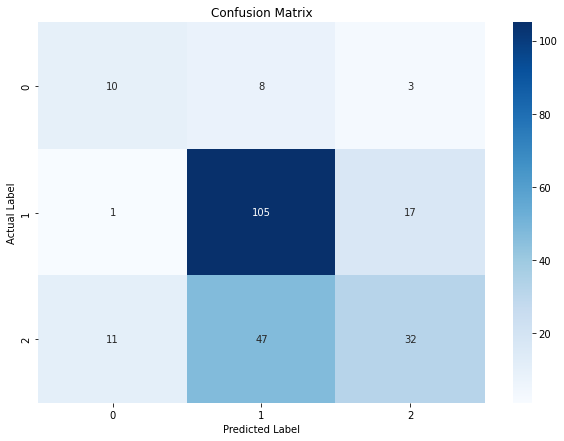

In [25]:
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Adjust xticklabels and yticklabels as needed
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


The first row (Actual Label 0) shows that there are 26 instances correctly predicted as class 0 (true positives for class 0), 16 instances where the actual class was 0 but the model predicted them as class 1 (false negatives for class 0 and false positives for class 1), and 0 instances where the actual class was 0 but the model predicted them as class 2.
The second row (Actual Label 1) indicates 24 instances where the actual class was 1 but the model predicted them as class 0, 126 instances correctly predicted as class 1, and 0 instances misclassified as class 2.
The third row (Actual Label 2) shows that 3 instances were misclassified as class 0, 39 instances were correctly predicted as class 2, and there were no instances misclassified as class 1.
The diagonal cells (from the top left to the bottom right) indicate correct predictions, where the predicted class matches the actual class. The other cells indicate incorrect predictions. Ideally, you want the numbers on the diagonal (true positives) to be as high as possible, indicating correct classifications.

The shading corresponds to the number of instances, with darker shades typically representing higher counts. In your confusion matrix, the majority of predictions fall on the diagonal for classes 0 and 1, which indicates that the model performs well for these classes. For class 2, while the model does have a correct prediction count of 39, it also has a number of instances misclassified as class 1.

It is also noticeable that class 0 and class 1 have a higher rate of being confused with each other, as evidenced by the 16 and 24 misclassifications between these two classes.

This matrix helps you understand not only the overall accuracy of the model but also provides insights into how it performs on each individual class, which is crucial for improving the model and addressing any class-specific biases or weaknesses.